# Geodesic Runtime

In [1]:
import os
import re
import pickle
import torch
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [2]:
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})


In [3]:
#Hyper-parameters

figure_path = '../figures/runtime/'
runtime_path = '../runtimes/timing_gpu/'

T = 100
methods = ["sgd", "rmsprop_momentum", "rmsprop", "adamax", "adam", "adagrad"]
methods = methods + ["ProbGEORCE_LS", "ProbGEORCE_Adaptive"]

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Helper functions

### Loading data

In [5]:
def load_experiment_results(
    base_path,
    lam_value,
    T,
    manifolds,
    methods,
):
    """
    Loads pickle files and extracts reg_energy and timing info.

    Returns:
        results[manifold][dimension][method] = {
            'reg_energy': float,
            'mu_time': float,
            'std_time': float
        }
    """
    results = defaultdict(lambda: defaultdict(dict))

    dim_pattern = re.compile(r"_d=(\d+)_T=")

    for manifold in manifolds:
        lam_dir = os.path.join(base_path, manifold, str(lam_value))
        if not os.path.isdir(lam_dir):
            continue

        for fname in os.listdir(lam_dir):
            if not fname.endswith(".pkl"):
                continue
            if f"_T={T}" not in fname:
                continue

            # extract dimension
            match = dim_pattern.search(fname)
            if match is None:
                continue
            dim = int(match.group(1))

            for method in methods:
                if not fname.startswith(f"{method}_{manifold}"):
                    continue

                fpath = os.path.join(lam_dir, fname)
                with open(fpath, "rb") as f:
                    data = pickle.load(f)

                entry = data[method]

                # Convert to torch scalars safely
                reg_energy = torch.as_tensor(entry["reg_energy"]).item()
                mu_time = torch.as_tensor(entry["mu_time"]).item()
                std_time = torch.as_tensor(entry["std_time"]).item()

                results[manifold][dim][method] = {
                    "reg_energy": reg_energy,
                    "mu_time": mu_time,
                    "std_time": std_time,
                }

    return results


In [6]:
def load_experiment_results_fixed_dim(
    base_path,
    dim_fixed,
    T,
    manifolds,
    methods,
):
    """
    Loads pickle files across all lambda folders for a fixed dimension.

    Returns:
        results_by_lam[lam][manifold][dim_fixed][method] = {
            'reg_energy': float,
            'mu_time': float,
            'std_time': float
        }
    """
    results_by_lam = defaultdict(
        lambda: defaultdict(lambda: defaultdict(dict))
    )

    dim_pattern = re.compile(rf"_d={dim_fixed}_T=")

    for manifold in manifolds:
        manifold_dir = os.path.join(base_path, manifold)
        if not os.path.isdir(manifold_dir):
            continue

        # Each subfolder is a lambda value
        for lam_str in os.listdir(manifold_dir):
            lam_dir = os.path.join(manifold_dir, lam_str)
            if not os.path.isdir(lam_dir):
                continue

            try:
                lam_value = float(lam_str)
            except ValueError:
                continue  # skip non-lambda folders

            for fname in os.listdir(lam_dir):
                if not fname.endswith(".pkl"):
                    continue
                if f"_T={T}" not in fname:
                    continue
                if not dim_pattern.search(fname):
                    continue

                for method in methods:
                    if not fname.startswith(f"{method}_{manifold}"):
                        continue

                    fpath = os.path.join(lam_dir, fname)
                    with open(fpath, "rb") as f:
                        data = pickle.load(f)

                    entry = data[method]

                    reg_energy = torch.as_tensor(entry["reg_energy"]).item()
                    mu_time = torch.as_tensor(entry["mu_time"]).item()
                    std_time = torch.as_tensor(entry["std_time"]).item()

                    results_by_lam[lam_value][manifold][dim_fixed][method] = {
                        "reg_energy": reg_energy,
                        "mu_time": mu_time,
                        "std_time": std_time,
                    }

    return results_by_lam


In [7]:
def load_experiment_results_fixed_dim(
    base_path,
    dim_fixed,
    T,
    manifolds,
    methods,
):
    """
    Loads pickle files across all lambda folders for a fixed dimension.

    Returns:
        results_by_lam[lam][manifold][dim_fixed][method] = {
            'reg_energy': float,
            'mu_time': float,
            'std_time': float
        }
    """
    results_by_lam = defaultdict(
        lambda: defaultdict(lambda: defaultdict(dict))
    )

    dim_pattern = re.compile(rf"_d={dim_fixed}_T=")

    for manifold in manifolds:
        manifold_dir = os.path.join(base_path, manifold)
        if not os.path.isdir(manifold_dir):
            continue

        # Each subfolder is a lambda value
        for lam_str in os.listdir(manifold_dir):
            lam_dir = os.path.join(manifold_dir, lam_str)
            if not os.path.isdir(lam_dir):
                continue
            lam_value = lam_str

            for fname in os.listdir(lam_dir):
                if not fname.endswith(".pkl"):
                    continue
                if f"_T={T}" not in fname:
                    continue
                if not dim_pattern.search(fname):
                    continue

                for method in methods:
                    if not fname.startswith(f"{method}_{manifold}"):
                        continue

                    fpath = os.path.join(lam_dir, fname)
                    with open(fpath, "rb") as f:
                        data = pickle.load(f)

                    entry = data[method]

                    reg_energy = torch.as_tensor(entry["reg_energy"]).item()
                    mu_time = torch.as_tensor(entry["mu_time"]).item()
                    std_time = torch.as_tensor(entry["std_time"]).item()

                    results_by_lam[lam_value][manifold][dim_fixed][method] = {
                        "reg_energy": reg_energy,
                        "mu_time": mu_time,
                        "std_time": std_time,
                    }

    return results_by_lam


### Writing LateX table

In [8]:
def print_latex_table(
    results,
    methods,
    caption="Regularized energy and runtime ($\\mu \\pm \\sigma$).",
    label="tab:results",
):
    """
    Prints a LaTeX table* where:
    - Manifold column is repeated as 'Manifold (dim=D)'
    - Best reg. energy and fastest runtime per row are bolded
    - Method names have '_' replaced by spaces
    - A horizontal line is added when the manifold changes
    """

    # Pretty method names
    method_names = [m.replace("_", " ") for m in methods]
    n_methods = len(methods)

    print(r"\begin{table*}[t]")
    print(r"\caption{" + caption + r"}")
    print(r"\centering")
    print(r"\resizebox{\textwidth}{!}{%")
    print(r"\begin{tabular}{l" + "cc" * n_methods + r"}")
    print(r"\toprule")

    # ---- Method group header ----
    header = " "
    for name in method_names:
        header += f" & \\multicolumn{{2}}{{c}}{{\\bfseries\\large {name}}}"
    header += r" \\"
    print(header)

    # cmidrules
    col = 2
    rules = []
    for _ in method_names:
        rules.append(f"\\cmidrule(lr){{{col}-{col+1}}}")
        col += 2
    print(" ".join(rules))

    # ---- Subheaders ----
    subheader = "Manifold"
    for _ in method_names:
        subheader += " & Reg. Energy & Runtime"
    subheader += r" \\"
    print(subheader)
    print(r"\midrule")

    # ---- Body ----
    prev_manifold = None

    for manifold in sorted(results.keys()):
        # Insert horizontal line if manifold changed (skip first)
        if prev_manifold is not None:
            print(r"\midrule")

        for dim in sorted(results[manifold].keys()):
            row_label = f"{manifold} (dim={dim})"

            # Collect values for bolding
            reg_vals = {}
            time_vals = {}
            for method in methods:
                if method in results[manifold][dim]:
                    r = results[manifold][dim][method]
                    reg_vals[method] = r["reg_energy"]
                    time_vals[method] = r["mu_time"]

            best_reg = min(reg_vals.values()) if reg_vals else None
            best_time = min(time_vals.values()) if time_vals else None

            row = row_label

            for method in methods:
                if method in results[manifold][dim]:
                    r = results[manifold][dim][method]

                    reg = f"{r['reg_energy']:.4f}"
                    time = f"{r['mu_time']:.3f} $\\pm$ {r['std_time']:.3f}"

                    if r["reg_energy"] == best_reg:
                        reg = rf"\textbf{{{reg}}}"
                    if r["mu_time"] == best_time:
                        time = rf"\textbf{{{time}}}"

                    row += f" & {reg} & {time}"
                else:
                    row += " & - & -"

            row += r" \\"
            print(row)

        prev_manifold = manifold  # update tracker

    print(r"\bottomrule")
    print(r"\end{tabular}}")
    print(r"\label{" + label + r"}")
    print(r"\end{table*}")


### Plot functions

In [9]:
def plot_vs_lambda(
    results_by_lam,
    manifold,
    dim,
    methods,
    n_runs=None,  # Optional: number of measurements per runtime
    figsize=(10, 4),
):
    # ---- Parse and sort lambdas numerically ----
    lam_pairs = []
    for lam_key in results_by_lam.keys():
        lam_val = float(lam_key.replace("d", ".")) if isinstance(lam_key, str) else float(lam_key)
        lam_pairs.append((lam_val, lam_key))
    lam_pairs.sort(key=lambda x: x[0])
    lams_numeric = [p[0] for p in lam_pairs]
    lams_keys = [p[1] for p in lam_pairs]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    for method in methods:
        reg_vals, time_vals, std_vals = [], [], []

        for lam_key in lams_keys:
            if (
                manifold in results_by_lam[lam_key]
                and dim in results_by_lam[lam_key][manifold]
                and method in results_by_lam[lam_key][manifold][dim]
            ):
                r = results_by_lam[lam_key][manifold][dim][method]
                reg_vals.append(r["reg_energy"])
                time_vals.append(r["mu_time"])
                std_vals.append(r["std_time"])
            else:
                reg_vals.append(float("nan"))
                time_vals.append(float("nan"))
                std_vals.append(0.0)

        reg_vals = torch.tensor(reg_vals)
        time_vals = torch.tensor(time_vals)
        std_vals = torch.tensor(std_vals)

        # ---- Compute 95% CI ----
        if n_runs is not None:
            ci95 = 1.96 * (std_vals / torch.sqrt(torch.tensor(n_runs)))
        else:
            ci95 = 1.96 * std_vals  # fallback if n_runs unknown

        label = method.replace("_", " ")
        axes[0].plot(lams_numeric, reg_vals, marker="o", label=label)
        axes[1].errorbar(
            lams_numeric, time_vals, yerr=ci95,
            marker="o", capsize=3, label=label
        )

    # ---- Axis formatting ----
    for ax in axes:
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.get_major_formatter().set_scientific(False)

    axes[0].set_title("Reg. Energy vs λ")
    axes[0].set_ylabel("Reg. Energy")

    axes[1].set_title("Runtime vs λ")
    axes[1].set_ylabel("Runtime")
    axes[1].legend(frameon=False)

    fig.suptitle(f"{manifold} (dim={dim})", fontsize=14)
    plt.tight_layout()
    fig.savefig(f"{figure_path}runtime_lam.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    plt.show()


In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def plot_vs_dimension(
    results,
    manifold,
    methods,
    lam_value,
    n_runs=None,  # Optional: number of measurements per runtime
    figsize=(10, 4),
):
    """
    1x2 plot:
      - Reg. Energy vs dimension
      - Runtime vs dimension
    for a fixed manifold and lambda.
    """

    dims = sorted(results[manifold].keys())

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    for method in methods:
        reg_vals, time_vals, std_vals = [], [], []

        for d in dims:
            if method in results[manifold][d]:
                r = results[manifold][d][method]
                reg_vals.append(r["reg_energy"])
                time_vals.append(r["mu_time"])
                std_vals.append(r["std_time"])
            else:
                reg_vals.append(float("nan"))
                time_vals.append(float("nan"))
                std_vals.append(0.0)

        reg_vals = torch.tensor(reg_vals)
        time_vals = torch.tensor(time_vals)
        std_vals = torch.tensor(std_vals)

        # ---- Compute 95% CI ----
        if n_runs is not None:
            ci95 = 1.96 * (std_vals / torch.sqrt(torch.tensor(n_runs)))
        else:
            ci95 = 1.96 * std_vals  # fallback if n_runs unknown

        label = method.replace("_", " ")
        axes[0].plot(dims, reg_vals, marker="o", label=label)
        axes[1].errorbar(dims, time_vals, yerr=ci95, marker="o", capsize=3, label=label)

    # ---- Axis formatting ----
    for ax in axes:
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.get_major_formatter().set_scientific(False)

    axes[0].set_xlabel("Dimension")
    axes[0].set_ylabel("Reg. Energy")

    axes[1].set_xlabel("Dimension")
    axes[1].set_ylabel("Runtime")
    axes[1].legend(frameon=False)

    plt.tight_layout()
    fig.savefig(f"{figure_path}runtime_dim.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    plt.show()


## Loading data

In [11]:
lam_value = "1d0"
manifolds = ["Sphere", "Ellipsoid", "SPDN", "T2", "Gaussian", "Frechet", "Cauchy", "Pareto"]

results = load_experiment_results(
    base_path=runtime_path,
    lam_value=lam_value,
    T=T,
    manifolds=manifolds,
    methods=methods,
)


In [12]:
manifolds = ["Sphere"]

results_lam = load_experiment_results_fixed_dim(
        runtime_path,
        10,
        100,
        manifolds,
    methods,
)

## Plotting data

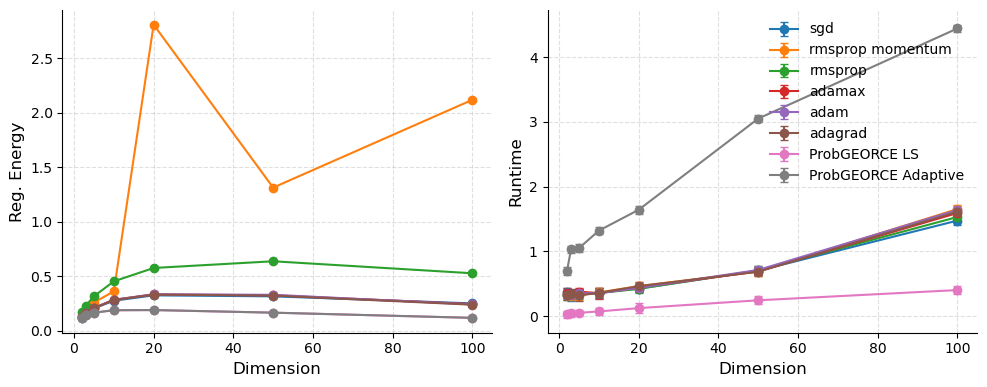

In [13]:
manifold = "Sphere"
lam_value = "1d0"

plot_vs_dimension(
    results,
    manifold,
    methods,
    lam_value,
 )

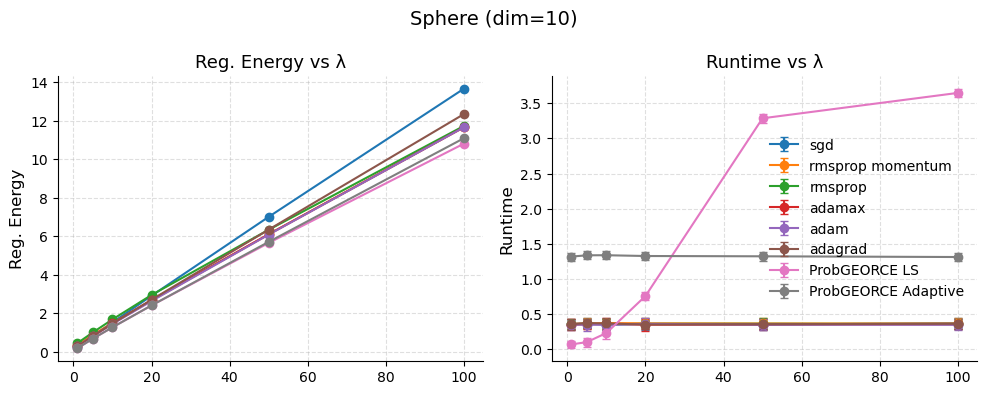

In [14]:
manifold = "Sphere"
dim = 10

plot_vs_lambda(results_lam,
    manifold,
    dim,
    methods,
              )

## Writing LateX table

In [15]:
print_latex_table(results, methods)

\begin{table*}[t]
\caption{Regularized energy and runtime ($\mu \pm \sigma$).}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccccccccccc}
\toprule
  & \multicolumn{2}{c}{\bfseries\large sgd} & \multicolumn{2}{c}{\bfseries\large rmsprop momentum} & \multicolumn{2}{c}{\bfseries\large rmsprop} & \multicolumn{2}{c}{\bfseries\large adamax} & \multicolumn{2}{c}{\bfseries\large adam} & \multicolumn{2}{c}{\bfseries\large adagrad} & \multicolumn{2}{c}{\bfseries\large ProbGEORCE LS} & \multicolumn{2}{c}{\bfseries\large ProbGEORCE Adaptive} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11} \cmidrule(lr){12-13} \cmidrule(lr){14-15} \cmidrule(lr){16-17}
Manifold & Reg. Energy & Runtime & Reg. Energy & Runtime & Reg. Energy & Runtime & Reg. Energy & Runtime & Reg. Energy & Runtime & Reg. Energy & Runtime & Reg. Energy & Runtime & Reg. Energy & Runtime \\
\midrule
Cauchy (dim=2) & 0.0853 & 0.344 $\pm$ 0.037 & 539.4545 & 0.350 $\pm$ 0.03

In [16]:
manifold = "Sphere"
save_path = ''.join((path, f"{manifold}", '/'))

NameError: name 'path' is not defined

In [ ]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [ ]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in sphere_estimates:
        sphere_estimates[dim] = dict(sphere_estimates[dim], **values)
    else:
        sphere_estimates[dim] = values